# How not to use random forest

This notebook supports a [Turo-engineering blog-post](to be created)

In [300]:
import random
import numpy as np
import pandas as pd

from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import r2_score

import seaborn as sns
import graphviz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


random.seed(1)

## Simulate data

In [289]:
data = pd.DataFrame(
    {
        'important_feature_poisson': np.random.poisson(5, 1000),
        'important_feature_dummy': np.random.binomial(1,0.5,1000),
        'random_feature_normal': np.random.normal(0,100,1000),
        'random_feature_dummy': np.random.binomial(1,0.5,1000)
    }
)

data['Y'] = np.random.normal(5,3,1000) * data['important_feature_poisson'] + np.random.normal(10,3,1000) * data['important_feature_dummy']

## Visualize the features

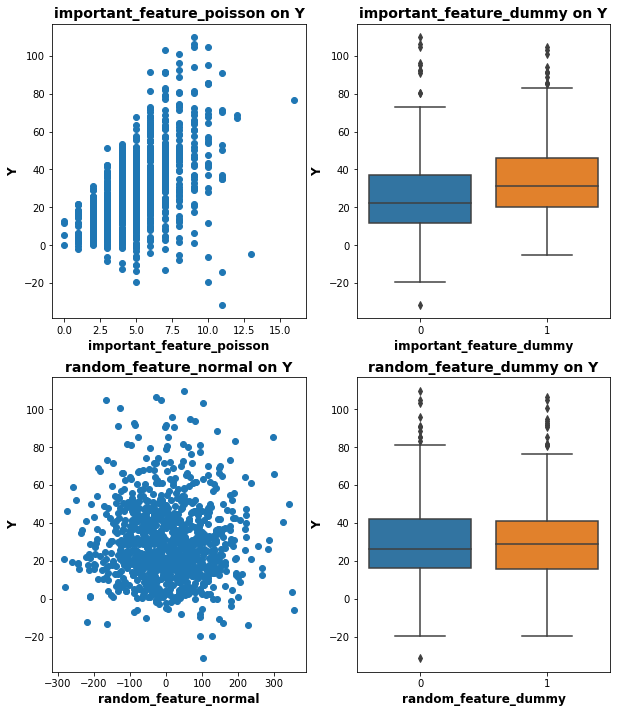

In [354]:
plt.rcParams['figure.figsize'] = [10, 5]

f, ((g_poisson, g_important_dummy), (g_normal, g_random_dummy)) = plt.subplots(2,2)
plt.subplots_adjust(bottom=1, top=2.8)
                             
g_poisson.scatter(x = data['important_feature_poisson'], y = data['Y'], )
g_poisson.set_xlabel('important_feature_poisson', fontweight = 'bold', fontsize = 12)
g_poisson.set_ylabel('Y', fontweight = 'bold', fontsize = 12)
g_poisson.set_title('important_feature_poisson on Y', fontweight = 'bold', fontsize = 14)

sns.boxplot(x = data['important_feature_dummy'], y = data['Y'], ax=g_important_dummy)
g_important_dummy.set_xlabel('important_feature_dummy', fontweight = 'bold', fontsize = 12)
g_important_dummy.set_ylabel('Y', fontweight = 'bold', fontsize = 12)
g_important_dummy.set_title('important_feature_dummy on Y', fontweight = 'bold', fontsize = 14)

g_normal.scatter(x = data['random_feature_normal'], y = data['Y'], )
g_normal.set_xlabel('random_feature_normal', fontweight = 'bold', fontsize = 12)
g_normal.set_ylabel('Y', fontweight = 'bold', fontsize = 12)
g_normal.set_title('random_feature_normal on Y', fontweight = 'bold', fontsize = 14)

sns.boxplot(x = data['random_feature_dummy'], y = data['Y'], ax=g_random_dummy)
g_random_dummy.set_xlabel('random_feature_dummy', fontweight = 'bold', fontsize = 12)
g_random_dummy.set_ylabel('Y', fontweight = 'bold', fontsize = 12)
g_random_dummy.set_title('random_feature_dummy on Y', fontweight = 'bold', fontsize = 14)

plt.show()

## Train a random forest

In [345]:
X = data.drop(['Y'], axis=1)
Y = data['Y']
reg = RandomForestRegressor(random_state=0)
reg.fit(X, Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

## Assess feature importance

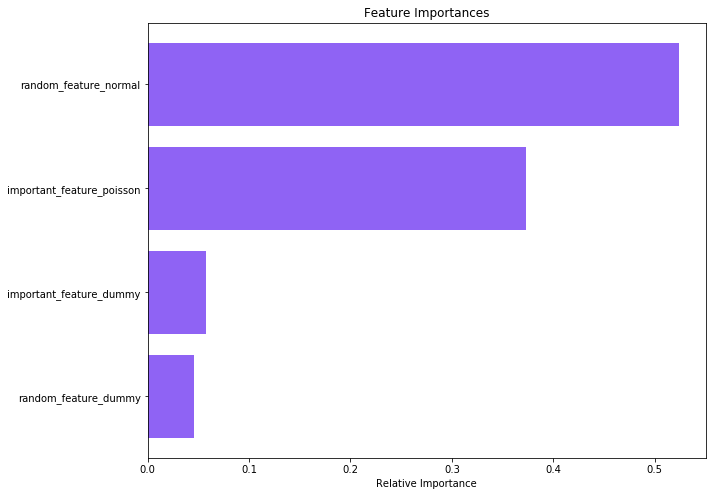

In [346]:
features = X.columns.values
importances = reg.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#8f63f4', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

## Assess feature importance with "mean decrease accuracy" on OOB sample

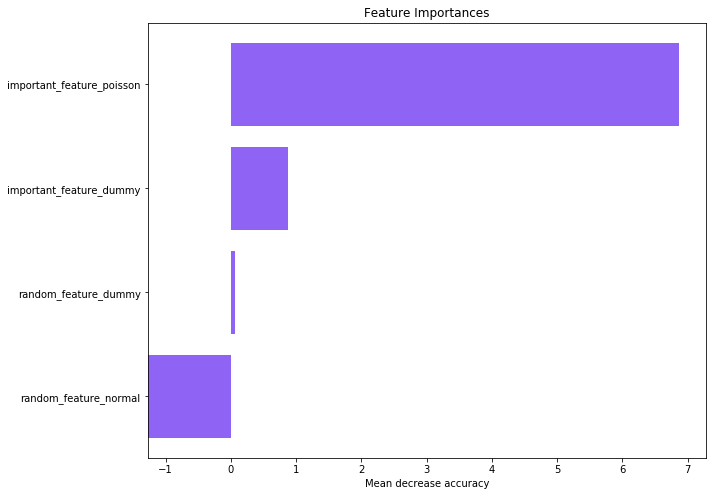

In [347]:
X = X.as_matrix()

#Took the code from http://blog.datadive.net/selecting-good-features-part-iii-random-forests/
for train_idx, test_idx in ShuffleSplit(len(X), 100, .3):
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    r = rf.fit(X_train, Y_train)
    acc = r2_score(Y_test, rf.predict(X_test))
    for i in range(X.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = r2_score(Y_test, rf.predict(X_t))
        scores[features[i]].append((acc-shuff_acc)/acc)

mda_features = [f for f in scores.keys()]
mda_importance = [(np.mean(score)) for score in scores.values()]
mda_indices = np.argsort(mda_importance)

plt.title('Feature Importances')
plt.barh(range(len(mda_indices)), [mda_importance[i] for i in mda_indices], color='#8f63f4', align='center')
plt.yticks(range(len(mda_indices)), [mda_features[i] for i in mda_indices])
plt.xlabel('Mean decrease accuracy')
plt.show()

## Extract a tree from the random forest

In [348]:
from sklearn import tree
with open('tree_0.dot', 'w' ) as my_file:
    my_file = tree.export_graphviz(reg.estimators_[0], out_file = my_file)

In [349]:
!dot -Tpng tree_0.dot -o tree.png

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.784594 to fit
